In [142]:
import numpy as np 
import pandas as pd 
import librosa
from librosa import feature
import librosa.display
import matplotlib.pyplot as plt
import os
import keras
from keras.layers import *
from keras import metrics
from keras.utils import to_categorical
import sklearn
from sklearn.model_selection import train_test_split
import csv
import IPython.display as ipd
from keras.regularizers import l1, l2, l1_l2

plt.style.use('ggplot')


In [75]:
random_file_path = './data/trital10.wav'

In [18]:
x, sr = librosa.load(random_file_path)
print(type(x), type(sr))

<class 'numpy.ndarray'> <class 'int'>


### This is a quick feature analysis of a random file in our dataset, ```trital10.wav```. This is the raw ```.wav``` file.

In [19]:
ipd.Audio(random_file_path)


### This is a wave plot of the first example file.

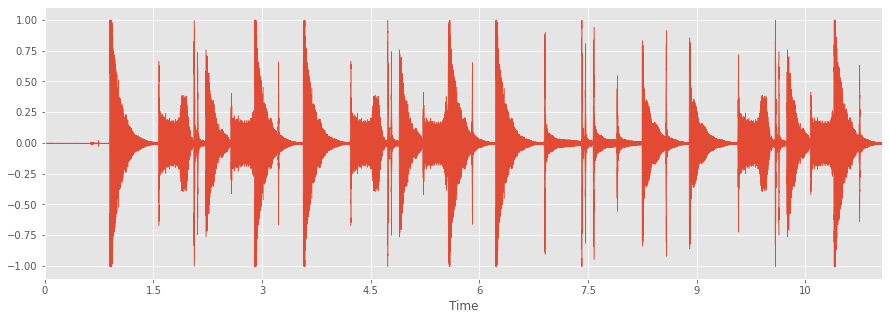

In [30]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sr)
plt.show()

### A chroma vector a a 12-element feature vector of the relative energy of each pitch class in the signal. The following plot is a chromagram of the first example file.

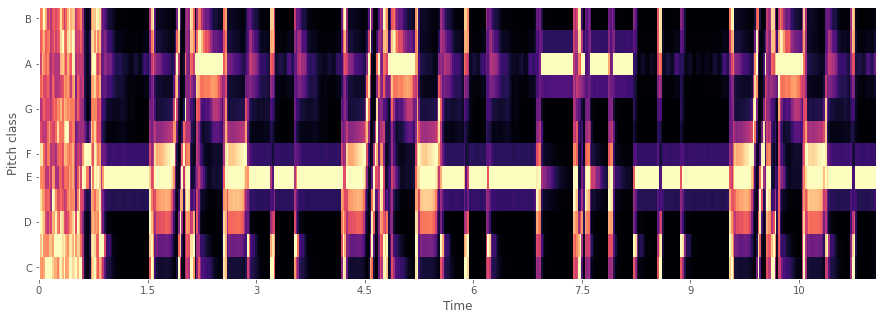

In [23]:
chromagram = librosa.feature.chroma_stft(x, sr=sr)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma')
plt.show()

The RMSE (root mean squared energy) of the signal, defined as

RMSE eqn to be put!

where x(n) is a time signal.

In [24]:
example_rmse = librosa.feature.rms(x)
print(example_rmse.shape)
print(np.mean(example_rmse))

(1, 498)
0.11107099


### The center of mass of the signal, e.g. the weighted mean of frequencies in the signal.

1380.3168211197892


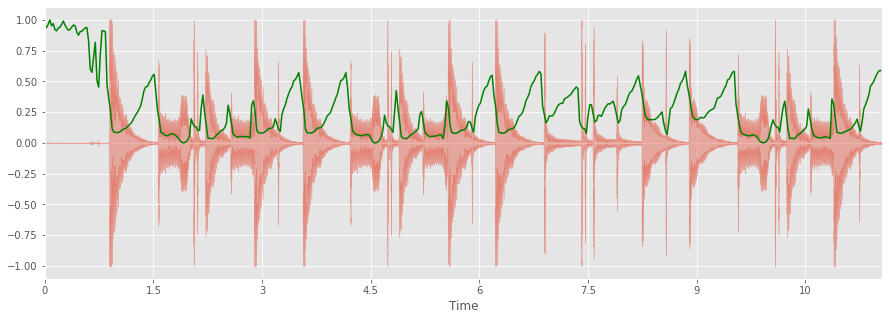

In [37]:
plt.figure(figsize=(15, 5))
example_spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
example_spectral_centroids.shape
frames = range(len(example_spectral_centroids))
t = librosa.frames_to_time(frames)
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(example_spectral_centroids), color='g')
print(np.mean(example_spectral_centroids))


Order p spectral bandwidth is defined as

Spectral bandwidth eqn to be put!

where S(k) is the spectral magnitude at frequency bin k, f(k) is the frequency at frequency bin k, and fc is the spectral centroid.

1918.287028489701


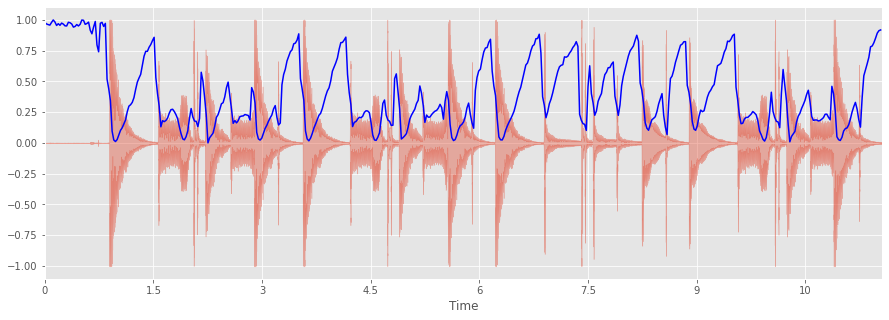

In [39]:
plt.figure(figsize=(15, 5))
example_spectral_bandwidth = librosa.feature.spectral_bandwidth(x, sr=sr)[0]
example_spectral_bandwidth.shape
frames = range(len(example_spectral_bandwidth))
t = librosa.frames_to_time(frames)
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(example_spectral_bandwidth), color='b')
print(np.mean(example_spectral_bandwidth))

### The spectral rolloff is a frequency below which a certain percentage of spectral energy lies.

2693.8772178557983


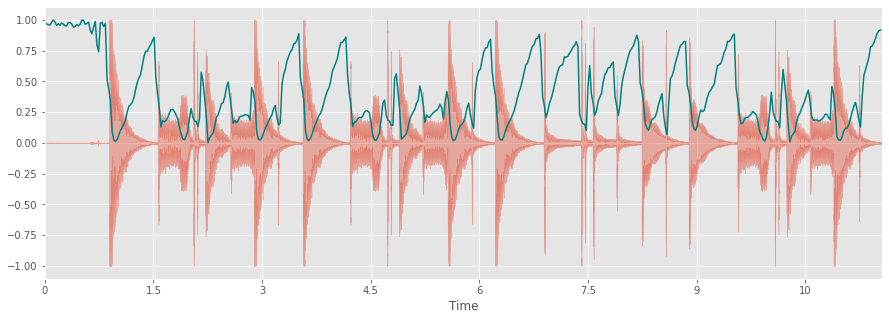

In [40]:
plt.figure(figsize=(15, 5))
example_spectral_rolloff = librosa.feature.spectral_rolloff(x, sr=sr)[0]
example_spectral_rolloff.shape
frames = range(len(example_spectral_rolloff))
t = librosa.frames_to_time(frames)
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(example_spectral_bandwidth), color='teal')
print(np.mean(example_spectral_rolloff))

### The zero crossing rate is the rate at which the signal changes sign (crosses y = 0).

31


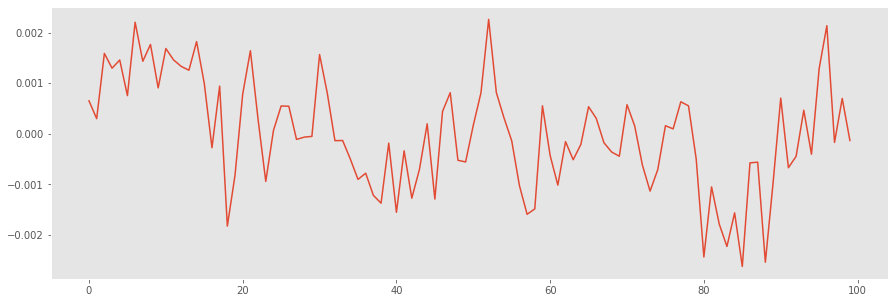

In [42]:
n0 = 9000
n1 = 9100
plt.figure(figsize=(15, 5))
plt.plot(x[n0:n1])
plt.grid()
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

### The Mel-Frequency Cepstral Coefficients (MFCCs) are a set of features which describe the representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

(20, 498)
-9.515644


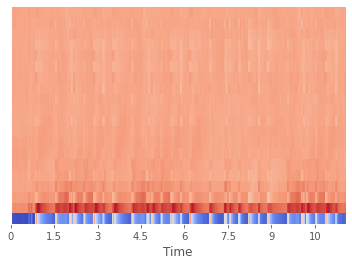

In [44]:
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
print(np.mean(mfccs))

## Features we've chosen : Chroma features, RMSE, Spectral Centroid, Spectral Bandwidth, Spectral Rolloff, Zero Crossing Rate, MFCCs

In [45]:
header = 'chroma_stft rms spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

## Creating the dataframe.

In [59]:
file = open('dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
taals = 'addhatrital bhajani dadra deepchandi ektal jhaptal rupak trital'.split()
for t in taals:
    for filename in os.listdir(f'./data/{t}'):
        taalfile = f'./data/{t}/{filename}'
        y, sr = librosa.load(taalfile, mono=True, duration=30)
        rms = librosa.feature.rms(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f' {np.mean(chroma_stft)} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)} '    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {t}'
        file = open('dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [81]:
df = pd.read_csv('./dataset.csv')

In [82]:
df.head()

chroma_stft       rms  spectral_centroid  spectral_bandwidth      rolloff  \
0     0.244509  0.053640        1811.952593         2323.015385  3981.201844   
1     0.254276  0.058988        1680.376629         2238.254300  3549.305475   
2     0.298049  0.042274        2104.442909         2481.985480  4638.433924   
3     0.324979  0.042272        2177.030466         2502.939254  4744.995117   
4     0.280060  0.056818        1768.944037         2279.975615  3734.613375   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  ...  \
0            0.060250 -398.591125  100.012894  32.302296  13.633352  ...   
1            0.065203 -394.727325  106.116402  39.377373  15.740703  ...   
2            0.080296 -415.507690   91.257645  29.125942  13.951041  ...   
3            0.088517 -418.281677   88.076683  28.738419  14.313146  ...   
4            0.072356 -393.842194  104.418884  38.059589  15.573009  ...   

     mfcc12    mfcc13    mfcc14    mfcc15    mfcc16     mfcc17     mfcc18  \
0  2.831584 -2.834994  1.165412 -2.396884  1.668640  -3.210190  -5.196571   
1 -0.221342 -4.972654  1.981220 -3.417812 -0.736427  -5.970107  -7.532811   
2  0.620940 -1.212108  0.607228 -0.885773 -2.151549  -9.895151 -11.089255   
3 -0.451522 -2.243045  0.222427 -2.972318 -6.207411 -12.357313  -9.125284   
4  0.064949 -3.714695  2.168054 -4.502642 -1.103919  -6.820243  -6.079304   

      mfcc19     mfcc20        label  
0  -8.775937 -11.214542  addhatrital  
1  -6.736145  -1.778272  addhatrital  
2 -11.662043  -6.629750  addhatrital  
3  -5.481705   3.474904  addhatrital  
4  -2.508776  -0.146714  addhatrital  

[5 rows x 27 columns]

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   chroma_stft         561 non-null    float64
 1   rms                 561 non-null    float64
 2   spectral_centroid   561 non-null    float64
 3   spectral_bandwidth  561 non-null    float64
 4   rolloff             561 non-null    float64
 5   zero_crossing_rate  561 non-null    float64
 6   mfcc1               561 non-null    float64
 7   mfcc2               561 non-null    float64
 8   mfcc3               561 non-null    float64
 9   mfcc4               561 non-null    float64
 10  mfcc5               561 non-null    float64
 11  mfcc6               561 non-null    float64
 12  mfcc7               561 non-null    float64
 13  mfcc8               561 non-null    float64
 14  mfcc9               561 non-null    float64
 15  mfcc10              561 non-null    float64
 16  mfcc11  

In [84]:
df.describe()

chroma_stft         rms  spectral_centroid  spectral_bandwidth  \
count   561.000000  561.000000         561.000000          561.000000   
mean      0.284492    0.085279        1428.867291         1942.876466   
std       0.034619    0.044435         288.824698          280.656259   
min       0.200601    0.036165         947.786489         1390.302982   
25%       0.257462    0.053732        1213.107638         1708.077397   
50%       0.282564    0.067702        1378.749857         1918.607083   
75%       0.310110    0.101193        1585.395474         2154.650605   
max       0.380309    0.287365        2365.084142         2622.179078   

           rolloff  zero_crossing_rate       mfcc1       mfcc2       mfcc3  \
count   561.000000          561.000000  561.000000  561.000000  561.000000   
mean   2691.658925            0.059784 -349.260324  120.523279   26.042604   
std     839.334127            0.012027   43.991448   15.982983    8.015809   
min    1364.308899            0.040342 -418.281677   82.728264   -3.466491   
25%    2037.932795            0.050570 -383.690460  108.116684   20.891312   
50%    2479.627120            0.057429 -357.617676  120.931709   26.606716   
75%    3171.217809            0.066013 -319.171814  133.651627   31.842678   
max    5101.686262            0.110565 -165.328964  154.146912   43.147766   

            mfcc4  ...      mfcc11      mfcc12      mfcc13      mfcc14  \
count  561.000000  ...  561.000000  561.000000  561.000000  561.000000   
mean    14.642584  ...   -3.723329   -1.022005   -6.150979   -0.447858   
std      5.013911  ...    2.802879    3.272838    3.636314    3.126087   
min      1.066282  ...  -10.722427  -11.407025  -16.794485   -9.797203   
25%     12.622837  ...   -5.832190   -3.522257   -8.475626   -2.474972   
50%     14.622822  ...   -3.848227   -0.894449   -5.815038    0.079956   
75%     17.666933  ...   -1.540260    1.415628   -3.552552    1.965188   
max     26.917906  ...    3.361814    6.582253    1.398377    5.515758   

           mfcc15      mfcc16      mfcc17      mfcc18      mfcc19      mfcc20  
count  561.000000  561.000000  561.000000  561.000000  561.000000  561.000000  
mean    -5.796079   -1.603946   -6.390728   -3.990135   -7.715699   -4.649104  
std      3.537266    3.146800    5.016963    5.037298    4.518972    4.867670  
min    -17.660593  -10.073713  -22.085997  -13.867086  -18.530825  -17.160799  
25%     -7.788827   -3.608106   -9.585712   -8.310212  -11.165448   -8.711082  
50%     -4.952309   -1.236602   -5.080621   -3.690530   -7.350810   -3.726137  
75%     -3.195061    0.670358   -2.427726    0.561143   -4.203798   -0.882811  
max      0.636470    5.843103    0.773160    5.750347    1.757758    6.694807  

[8 rows x 26 columns]

In [85]:
df['label']

0      addhatrital
1      addhatrital
2      addhatrital
3      addhatrital
4      addhatrital
          ...     
556         trital
557         trital
558         trital
559         trital
560         trital
Name: label, Length: 561, dtype: object

### Mapping the taal names(labels) to integers from 0 to 7(Label Encoding).


In [86]:
d = dict(zip(taals, range(0,8)))
d

{'addhatrital': 0,
 'bhajani': 1,
 'dadra': 2,
 'deepchandi': 3,
 'ektal': 4,
 'jhaptal': 5,
 'rupak': 6,
 'trital': 7}

In [87]:
df['label']

0      addhatrital
1      addhatrital
2      addhatrital
3      addhatrital
4      addhatrital
          ...     
556         trital
557         trital
558         trital
559         trital
560         trital
Name: label, Length: 561, dtype: object

In [88]:
df['label'] = df['label'].map(d)

In [91]:
df['label']

0      0
1      0
2      0
3      0
4      0
      ..
556    7
557    7
558    7
559    7
560    7
Name: label, Length: 561, dtype: int64

### The following code performs an 75/15/10 (train/validation/test) split on the data after splitting it into train and test data. The order of the data is also randomized. The label data is also changed to one-hot encoding.

In [125]:
X = df.drop('label', axis=1)
y = df['label']

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

"""https://datascience.stackexchange.com/a/53161/73311"""

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

### Creating a Keras Sequential model. The last layer has a softmax activation.

In [144]:
model = keras.models.Sequential()
model.add(Dense(32, input_dim = 26, activation='relu'))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dense(8, activation='softmax'))

In [145]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [146]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 32)                864       
_________________________________________________________________
dense_26 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_27 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_28 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_29 (Dense)             (None, 8)                 1032      
Total params: 28,840
Trainable params: 28,840
Non-trainable params: 0
_________________________________________________________________


In [147]:
history = model.fit(x_train, y_train,
                    epochs=1000,
                    batch_size=10,
                    shuffle=True,
                    validation_data=(x_val, y_val))

Epoch 1/1000
42/42 [==============================] - 0s 4ms/step - loss: 43.8225 - acc: 0.1548 - val_loss: 13.1344 - val_acc: 0.1548
Epoch 2/1000
42/42 [==============================] - 0s 1ms/step - loss: 8.8142 - acc: 0.1857 - val_loss: 8.1342 - val_acc: 0.2976
Epoch 3/1000
42/42 [==============================] - 0s 1ms/step - loss: 9.2059 - acc: 0.2024 - val_loss: 7.6232 - val_acc: 0.2381
Epoch 4/1000
42/42 [==============================] - 0s 1ms/step - loss: 6.9767 - acc: 0.1833 - val_loss: 4.6764 - val_acc: 0.1548
Epoch 5/1000
42/42 [==============================] - 0s 1ms/step - loss: 6.0776 - acc: 0.1786 - val_loss: 4.6801 - val_acc: 0.2619
Epoch 6/1000
42/42 [==============================] - 0s 1ms/step - loss: 5.3583 - acc: 0.2238 - val_loss: 7.6665 - val_acc: 0.2143
Epoch 7/1000
42/42 [==============================] - 0s 1ms/step - loss: 5.0306 - acc: 0.2690 - val_loss: 6.7558 - val_acc: 0.1905
Epoch 8/1000
42/42 [==============================] - 0s 1ms/step - loss: 

42/42 [==============================] - 0s 1ms/step - loss: 0.9673 - acc: 0.7881 - val_loss: 1.2049 - val_acc: 0.6905
Epoch 63/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.8661 - acc: 0.8286 - val_loss: 1.1229 - val_acc: 0.7024
Epoch 64/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.8988 - acc: 0.8381 - val_loss: 0.9751 - val_acc: 0.7619
Epoch 65/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.9101 - acc: 0.8119 - val_loss: 1.0774 - val_acc: 0.7381
Epoch 66/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.9462 - acc: 0.7881 - val_loss: 1.0878 - val_acc: 0.7024
Epoch 67/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.7884 - acc: 0.8833 - val_loss: 0.8992 - val_acc: 0.8333
Epoch 68/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.7680 - acc: 0.8857 - val_loss: 0.9550 - val_acc: 0.7857
Epoch 69/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.8404 -

42/42 [==============================] - 0s 1ms/step - loss: 0.6521 - acc: 0.8833 - val_loss: 0.6850 - val_acc: 0.8810
Epoch 124/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.6458 - acc: 0.8690 - val_loss: 0.7983 - val_acc: 0.8333
Epoch 125/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.7244 - acc: 0.8571 - val_loss: 0.8195 - val_acc: 0.8095
Epoch 126/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.6220 - acc: 0.8738 - val_loss: 0.8798 - val_acc: 0.7857
Epoch 127/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.5584 - acc: 0.9024 - val_loss: 1.0196 - val_acc: 0.7619
Epoch 128/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.4716 - acc: 0.9429 - val_loss: 0.7259 - val_acc: 0.8690
Epoch 129/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.5152 - acc: 0.9310 - val_loss: 0.9813 - val_acc: 0.7976
Epoch 130/1000
42/42 [==============================] - 0s 1ms/step - loss: 0

42/42 [==============================] - 0s 1ms/step - loss: 0.4715 - acc: 0.9024 - val_loss: 1.0203 - val_acc: 0.7857
Epoch 185/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.5231 - acc: 0.8976 - val_loss: 0.7459 - val_acc: 0.8810
Epoch 186/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.3205 - acc: 0.9619 - val_loss: 0.3618 - val_acc: 0.9524
Epoch 187/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.2926 - acc: 0.9738 - val_loss: 0.5304 - val_acc: 0.8929
Epoch 188/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.3321 - acc: 0.9595 - val_loss: 0.5118 - val_acc: 0.8929
Epoch 189/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.7119 - acc: 0.8500 - val_loss: 1.1905 - val_acc: 0.7143
Epoch 190/1000
42/42 [==============================] - 0s 1ms/step - loss: 1.3219 - acc: 0.7048 - val_loss: 0.6792 - val_acc: 0.8095
Epoch 191/1000
42/42 [==============================] - 0s 1ms/step - loss: 0

42/42 [==============================] - 0s 1ms/step - loss: 0.3780 - acc: 0.9119 - val_loss: 0.7246 - val_acc: 0.8095
Epoch 246/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.3473 - acc: 0.9262 - val_loss: 0.3541 - val_acc: 0.9048
Epoch 247/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.2688 - acc: 0.9548 - val_loss: 0.4812 - val_acc: 0.8452
Epoch 248/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.2393 - acc: 0.9619 - val_loss: 0.4148 - val_acc: 0.8929
Epoch 249/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.2236 - acc: 0.9667 - val_loss: 0.4356 - val_acc: 0.9286
Epoch 250/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.4743 - acc: 0.8786 - val_loss: 0.9513 - val_acc: 0.7143
Epoch 251/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.4281 - acc: 0.9024 - val_loss: 0.3750 - val_acc: 0.9167
Epoch 252/1000
42/42 [==============================] - 0s 1ms/step - loss: 0

42/42 [==============================] - 0s 1ms/step - loss: 0.1754 - acc: 0.9714 - val_loss: 0.4263 - val_acc: 0.8810
Epoch 307/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.3866 - acc: 0.9048 - val_loss: 0.6611 - val_acc: 0.8690
Epoch 308/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.3216 - acc: 0.9190 - val_loss: 0.3440 - val_acc: 0.9167
Epoch 309/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.2067 - acc: 0.9667 - val_loss: 0.2965 - val_acc: 0.9286
Epoch 310/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.2740 - acc: 0.9452 - val_loss: 0.3005 - val_acc: 0.9286
Epoch 311/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.1609 - acc: 0.9857 - val_loss: 0.2791 - val_acc: 0.9167
Epoch 312/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.1585 - acc: 0.9810 - val_loss: 0.3740 - val_acc: 0.9286
Epoch 313/1000
42/42 [==============================] - 0s 1ms/step - loss: 0

42/42 [==============================] - 0s 1ms/step - loss: 0.1663 - acc: 0.9738 - val_loss: 0.2461 - val_acc: 0.9405
Epoch 368/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.1310 - acc: 0.9857 - val_loss: 0.3691 - val_acc: 0.9167
Epoch 369/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.1232 - acc: 0.9905 - val_loss: 0.3858 - val_acc: 0.9167
Epoch 370/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.1131 - acc: 0.9905 - val_loss: 0.3656 - val_acc: 0.9167
Epoch 371/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.1204 - acc: 0.9881 - val_loss: 0.2304 - val_acc: 0.9405
Epoch 372/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.1771 - acc: 0.9714 - val_loss: 0.3818 - val_acc: 0.8571
Epoch 373/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.2924 - acc: 0.9238 - val_loss: 0.2897 - val_acc: 0.8929
Epoch 374/1000
42/42 [==============================] - 0s 1ms/step - loss: 0

42/42 [==============================] - 0s 1ms/step - loss: 0.0865 - acc: 0.9976 - val_loss: 0.1540 - val_acc: 0.9524
Epoch 429/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0913 - acc: 0.9929 - val_loss: 0.2940 - val_acc: 0.9048
Epoch 430/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.1402 - acc: 0.9738 - val_loss: 0.5016 - val_acc: 0.8690
Epoch 431/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.2000 - acc: 0.9595 - val_loss: 0.1977 - val_acc: 0.9524
Epoch 432/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.2463 - acc: 0.9310 - val_loss: 0.3466 - val_acc: 0.8929
Epoch 433/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.2182 - acc: 0.9500 - val_loss: 0.3763 - val_acc: 0.8929
Epoch 434/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.4373 - acc: 0.8714 - val_loss: 1.2885 - val_acc: 0.7143
Epoch 435/1000
42/42 [==============================] - 0s 1ms/step - loss: 0

42/42 [==============================] - 0s 1ms/step - loss: 0.0811 - acc: 1.0000 - val_loss: 0.2018 - val_acc: 0.9405
Epoch 490/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0758 - acc: 1.0000 - val_loss: 0.1757 - val_acc: 0.9405
Epoch 491/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0992 - acc: 0.9881 - val_loss: 0.1964 - val_acc: 0.9286
Epoch 492/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.1144 - acc: 0.9833 - val_loss: 0.1634 - val_acc: 0.9643
Epoch 493/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.1012 - acc: 0.9857 - val_loss: 0.1759 - val_acc: 0.9524
Epoch 494/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0998 - acc: 0.9881 - val_loss: 0.4096 - val_acc: 0.9167
Epoch 495/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0882 - acc: 0.9952 - val_loss: 0.1975 - val_acc: 0.8929
Epoch 496/1000
42/42 [==============================] - 0s 1ms/step - loss: 0

42/42 [==============================] - 0s 1ms/step - loss: 0.0658 - acc: 1.0000 - val_loss: 0.1385 - val_acc: 0.9524
Epoch 551/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0773 - acc: 0.9905 - val_loss: 0.2153 - val_acc: 0.9405
Epoch 552/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.1041 - acc: 0.9786 - val_loss: 0.1992 - val_acc: 0.9286
Epoch 553/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.1166 - acc: 0.9762 - val_loss: 0.2173 - val_acc: 0.9286
Epoch 554/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0981 - acc: 0.9857 - val_loss: 0.2263 - val_acc: 0.9167
Epoch 555/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0802 - acc: 0.9929 - val_loss: 0.1335 - val_acc: 0.9762
Epoch 556/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0825 - acc: 0.9881 - val_loss: 0.2410 - val_acc: 0.9405
Epoch 557/1000
42/42 [==============================] - 0s 1ms/step - loss: 0

42/42 [==============================] - 0s 1ms/step - loss: 0.0813 - acc: 0.9952 - val_loss: 0.1411 - val_acc: 0.9643
Epoch 612/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0854 - acc: 0.9905 - val_loss: 0.3060 - val_acc: 0.9286
Epoch 613/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0953 - acc: 0.9857 - val_loss: 0.3569 - val_acc: 0.8929
Epoch 614/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0927 - acc: 0.9881 - val_loss: 0.1458 - val_acc: 0.9524
Epoch 615/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0784 - acc: 0.9929 - val_loss: 0.2242 - val_acc: 0.9405
Epoch 616/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0945 - acc: 0.9833 - val_loss: 0.3506 - val_acc: 0.8929
Epoch 617/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.3145 - acc: 0.9167 - val_loss: 0.3872 - val_acc: 0.8929
Epoch 618/1000
42/42 [==============================] - 0s 1ms/step - loss: 0

42/42 [==============================] - 0s 1ms/step - loss: 0.1043 - acc: 0.9786 - val_loss: 0.1491 - val_acc: 0.9643
Epoch 673/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0993 - acc: 0.9810 - val_loss: 0.2458 - val_acc: 0.9167
Epoch 674/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.1055 - acc: 0.9857 - val_loss: 0.1587 - val_acc: 0.9643
Epoch 675/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0786 - acc: 0.9905 - val_loss: 0.1528 - val_acc: 0.9405
Epoch 676/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0816 - acc: 0.9905 - val_loss: 0.1266 - val_acc: 0.9524
Epoch 677/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0554 - acc: 0.9976 - val_loss: 0.1217 - val_acc: 0.9405
Epoch 678/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0548 - acc: 0.9976 - val_loss: 0.1604 - val_acc: 0.9643
Epoch 679/1000
42/42 [==============================] - 0s 1ms/step - loss: 0

42/42 [==============================] - 0s 1ms/step - loss: 0.0623 - acc: 0.9929 - val_loss: 0.2202 - val_acc: 0.8929
Epoch 734/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.2453 - acc: 0.9262 - val_loss: 0.4515 - val_acc: 0.8690
Epoch 735/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.2693 - acc: 0.9238 - val_loss: 0.7308 - val_acc: 0.8095
Epoch 736/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.3736 - acc: 0.8952 - val_loss: 0.1915 - val_acc: 0.9167
Epoch 737/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.1062 - acc: 0.9857 - val_loss: 0.1362 - val_acc: 0.9643
Epoch 738/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0817 - acc: 0.9881 - val_loss: 0.2365 - val_acc: 0.9048
Epoch 739/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.2881 - acc: 0.9119 - val_loss: 0.2145 - val_acc: 0.9405
Epoch 740/1000
42/42 [==============================] - 0s 1ms/step - loss: 0

42/42 [==============================] - 0s 1ms/step - loss: 0.3684 - acc: 0.9095 - val_loss: 0.4274 - val_acc: 0.9286
Epoch 795/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.2161 - acc: 0.9262 - val_loss: 0.2245 - val_acc: 0.9167
Epoch 796/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0717 - acc: 0.9952 - val_loss: 0.1748 - val_acc: 0.9524
Epoch 797/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0651 - acc: 0.9929 - val_loss: 0.1023 - val_acc: 0.9762
Epoch 798/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0687 - acc: 0.9905 - val_loss: 0.2104 - val_acc: 0.9286
Epoch 799/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0552 - acc: 0.9976 - val_loss: 0.1349 - val_acc: 0.9524
Epoch 800/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0584 - acc: 0.9929 - val_loss: 0.3347 - val_acc: 0.9286
Epoch 801/1000
42/42 [==============================] - 0s 1ms/step - loss: 0

42/42 [==============================] - 0s 1ms/step - loss: 0.0482 - acc: 1.0000 - val_loss: 0.1024 - val_acc: 0.9643
Epoch 856/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0467 - acc: 0.9976 - val_loss: 0.1025 - val_acc: 0.9762
Epoch 857/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0649 - acc: 0.9952 - val_loss: 0.1027 - val_acc: 0.9524
Epoch 858/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0532 - acc: 0.9952 - val_loss: 0.1233 - val_acc: 0.9643
Epoch 859/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0511 - acc: 0.9929 - val_loss: 0.1286 - val_acc: 0.9405
Epoch 860/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0655 - acc: 0.9833 - val_loss: 0.1765 - val_acc: 0.9405
Epoch 861/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.1164 - acc: 0.9714 - val_loss: 0.1267 - val_acc: 0.9524
Epoch 862/1000
42/42 [==============================] - 0s 1ms/step - loss: 0

42/42 [==============================] - 0s 1ms/step - loss: 0.0420 - acc: 0.9976 - val_loss: 0.1262 - val_acc: 0.9405
Epoch 917/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0862 - acc: 0.9833 - val_loss: 0.1352 - val_acc: 0.9405
Epoch 918/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0657 - acc: 0.9905 - val_loss: 0.1532 - val_acc: 0.9405
Epoch 919/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.1018 - acc: 0.9786 - val_loss: 0.1446 - val_acc: 0.9643
Epoch 920/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.1106 - acc: 0.9738 - val_loss: 0.1945 - val_acc: 0.9286
Epoch 921/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0608 - acc: 0.9857 - val_loss: 0.1242 - val_acc: 0.9643
Epoch 922/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0494 - acc: 0.9952 - val_loss: 0.1806 - val_acc: 0.9405
Epoch 923/1000
42/42 [==============================] - 0s 1ms/step - loss: 0

42/42 [==============================] - 0s 1ms/step - loss: 0.0560 - acc: 0.9905 - val_loss: 0.2837 - val_acc: 0.8810
Epoch 978/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.1266 - acc: 0.9714 - val_loss: 0.2584 - val_acc: 0.9286
Epoch 979/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0586 - acc: 0.9929 - val_loss: 0.1024 - val_acc: 0.9762
Epoch 980/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0480 - acc: 0.9952 - val_loss: 0.1187 - val_acc: 0.9643
Epoch 981/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0483 - acc: 0.9976 - val_loss: 0.1191 - val_acc: 0.9524
Epoch 982/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0423 - acc: 1.0000 - val_loss: 0.1034 - val_acc: 0.9643
Epoch 983/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0407 - acc: 1.0000 - val_loss: 0.1552 - val_acc: 0.9524
Epoch 984/1000
42/42 [==============================] - 0s 1ms/step - loss: 0

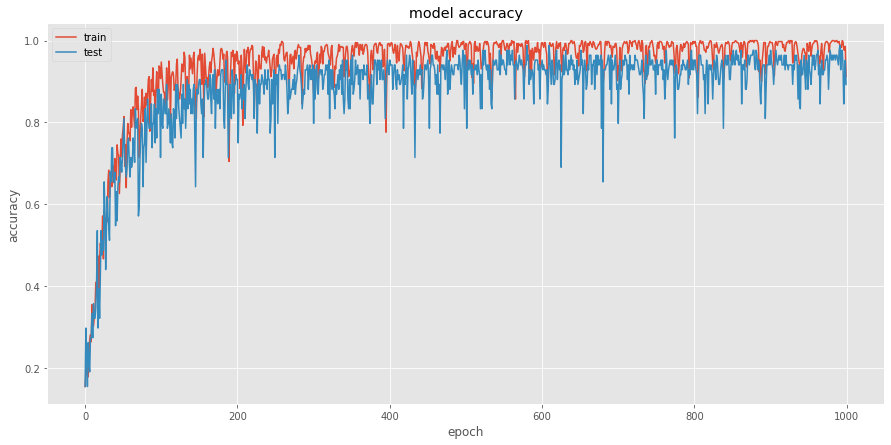

In [148]:
plt.figure(figsize=(15, 7))
plt.style.use('ggplot')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

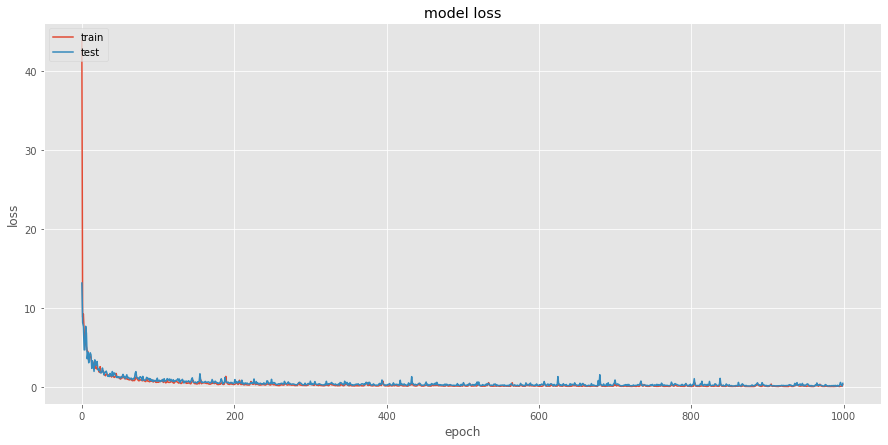

In [149]:
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

### Evaluate model!

In [150]:
loss = model.evaluate(x_test, y_test)


2/2 [==============================] - 0s 1ms/step - loss: 0.1489 - acc: 0.9649
